### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 4
### Due: Friday, Feb 21st at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [61]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm
#import seaborn as sns
import corner


data = np.load("/home/shwetha/repos/ASTR_3300_S2025/coursework/homeworks/hw_data/hw4_data_1.npy")

# Question 1
x, dx= data[:,0], data[:,1]
weights = 1/dx**2

w_mean = np.sum(weights*x)/np.sum(weights)
std_err = np.sqrt(1/np.sum(weights))

print("Weighted Mean:", w_mean)
print("Standard Error:", std_err)


Weighted Mean: 4.942118214425304
Standard Error: 0.43024334605205083


In [13]:
mu1 = np.mean(x)

def log_L(w_mean, x, std_err):
    return 0.5*np.sum(((x-w_mean)**2)/std_err**2)

result = minimize(lambda mu: log_L(mu, x, dx),x0=[mu1])

print("Best-fit mean:", result.x[0])

Best-fit mean: 4.9421182131077375


In [62]:
def ln_L(mu0,x_i,err):
    return 0.5*np.log(2*np.pi*err**2) + np.sum((x_i-mu0)**2/(2*err**2))
    
mu1 = np.mean(x)
fit = minimize(lambda mu: log_L(mu, x, std_err),x0=[mu1])


mu_num1 = fit.x[0]
print("Best Fit Mean (Standard Error on Sample Mean):", np.round(mu_num1,3))


def nlnL(mu0,x_i,err_i): # for hetroscedastic errors
    return 0.5*np.log(2*np.pi) + np.sum(np.log(err_i) + (x_i-mu0)**2/(2*err_i**2))

   
#best_fit = minimize(ln_L,np.mean(x), args=(x, dx)) # took simple np.mean(x) as the starting point
minimize(lambda mu: log_L(mu, x, dx),x0=[mu1])

mu_num = fit.x[0]
print("Best Fit Mean (Hetro errors):", np.round(mu_num,3))

Best Fit Mean (Standard Error on Sample Mean): 5.106
Best Fit Mean (Hetro errors): 5.106


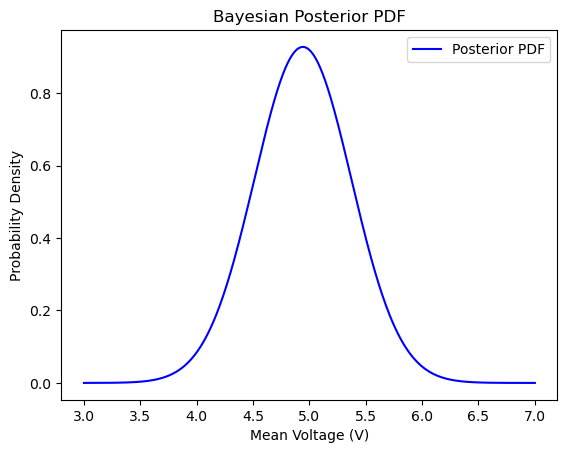

In [66]:
mu_values = np.linspace(3, 7, 500)


likelihood = np.ones_like(mu_values)

for i, mu in enumerate(mu_values):
    likelihood[i] = np.prod((1/np.sqrt(2*np.pi*dx**2))*np.exp(-((x-mu)**2)/(2*dx**2)))

# Normalize to get posterior density
posterior_pdf = likelihood/np.trapz(likelihood, mu_values) 

plt.plot(mu_values, posterior_pdf, label="Posterior PDF", color='b')
plt.xlabel("Mean Voltage (V)")
plt.ylabel("Probability Density")
plt.title("Bayesian Posterior PDF")
plt.legend()
plt.show()


68.3% Credible Region: (4.515030060120241, 5.372745490981964)
MAP Estimate of Mean Voltage: 4.939879759519038


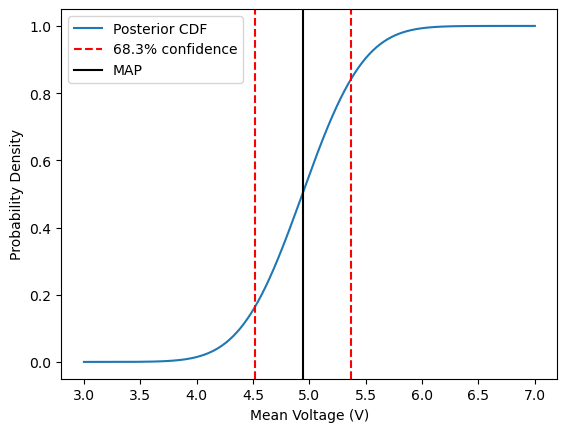

In [67]:
space = mu_values[1] - mu_values[0]  # Grid spacing

#CDF
posterior_cdf = np.cumsum(posterior_pdf)*space
posterior_cdf/= posterior_cdf[-1]  # Normalize CDF to range

lower_bound = mu_values[np.searchsorted(posterior_cdf, 0.1585)]
upper_bound = mu_values[np.searchsorted(posterior_cdf, 0.8415)]

# Compute sample mean and standard error
sample_std = np.std(x, ddof=1)
n = len(x)
sem_std = sample_std/np.sqrt(n)
sem_uncertainty = np.sqrt(np.sum(dx**2))/n
sem_total = np.sqrt(sem_std**2+sem_uncertainty**2)

# Compute MAP estimate (max of posterior)
map_estimate = mu_values[np.argmax(posterior_pdf)]

# Print results
print(f"68.3% Credible Region: ({lower_bound}, {upper_bound})")
print(f"MAP Estimate of Mean Voltage: {map_estimate}")


plt.plot(mu_values, posterior_cdf, label="Posterior CDF")
plt.axvline(lower_bound, color='r', linestyle='--', label="68.3% confidence")
plt.axvline(upper_bound, color='r', linestyle='--')
plt.axvline(map_estimate, color='black', label="MAP")
plt.xlabel("Mean Voltage (V)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()


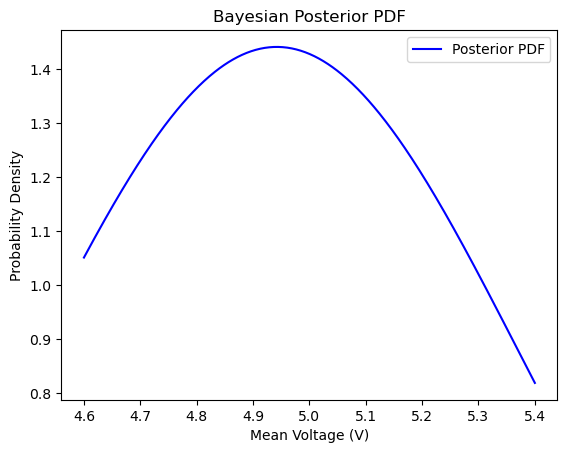

In [72]:
mu_values = np.linspace(4.6, 5.4, 500)


likelihood = np.ones_like(mu_values)

for i, mu in enumerate(mu_values):
    likelihood[i] = np.prod((1/np.sqrt(2*np.pi*dx**2))*np.exp(-((x-mu)**2)/(2*dx**2)))

# Normalize to get posterior density
posterior_pdf = likelihood/np.trapz(likelihood, mu_values) 

plt.plot(mu_values, posterior_pdf, label="Posterior PDF", color='b')
plt.xlabel("Mean Voltage (V)")
plt.ylabel("Probability Density")
plt.title("Bayesian Posterior PDF")
plt.legend()
plt.show()


68.3% Credible Region: (4.734669338677355, 5.238076152304609)
MAP Estimate of Mean Voltage: 4.941482965931864


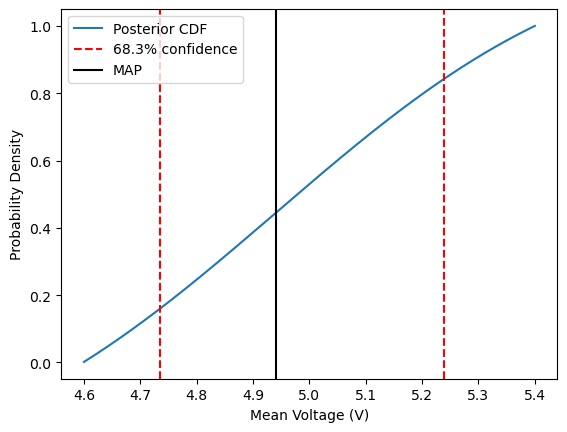

In [76]:
space = mu_values[1] - mu_values[0]  # Grid spacing

#CDF
posterior_cdf = np.cumsum(posterior_pdf)*space
posterior_cdf/= posterior_cdf[-1]  # Normalize CDF to range

lower_bound = mu_values[np.searchsorted(posterior_cdf, 0.1585)]
upper_bound = mu_values[np.searchsorted(posterior_cdf, 0.8415)]

# Compute sample mean and standard error
sample_std = np.std(x, ddof=1)
n = len(x)
sem_std = sample_std/np.sqrt(n)
sem_uncertainty = np.sqrt(np.sum(dx**2))/n
sem_total = np.sqrt(sem_std**2+sem_uncertainty**2)

# Compute MAP estimate (max of posterior)
map_estimate = mu_values[np.argmax(posterior_pdf)]

# Print results
print(f"68.3% Credible Region: ({lower_bound}, {upper_bound})")
print(f"MAP Estimate of Mean Voltage: {map_estimate}")


plt.plot(mu_values, posterior_cdf, label="Posterior CDF")
plt.axvline(lower_bound, color='r', linestyle='--', label="68.3% confidence")
plt.axvline(upper_bound, color='r', linestyle='--')
plt.axvline(map_estimate, color='black', label="MAP")
plt.xlabel("Mean Voltage (V)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()


<span style="color:red">NP: missing #7 and #8. -3 pts each.</span>

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

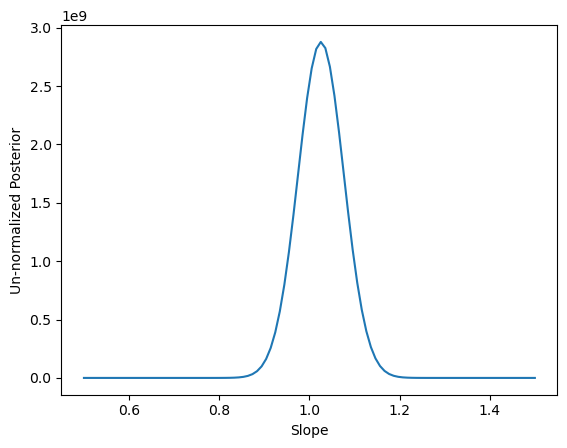

In [85]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

x, y, sigma_y = np.load('/home/shwetha/repos/ASTR_3300_S2025/coursework/homeworks/hw_data/hw4_data_2.npy')
slope_grid = np.linspace(0.5, 1.5, 100)
posterior = np.array([np.exp(logL([-0.23, slope], (x, y, sigma_y))) for slope in slope_grid])


plt.plot(slope_grid, posterior)
plt.xlabel('Slope')
plt.ylabel('Un-normalized Posterior')
plt.show()



3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

In [88]:
evidence = np.trapz(posterior, slope_grid)
print("Bayesian evidence:",evidence)

Bayesian evidence: 365684733.16065943


<span style="color:red">NP: missing #4-6. -3 pts each.</span>

### Solution